# Innovación e Incentivos dentro de las Organizaciones: Una estimación predicativa con modelos de Machine Learning 
### Andres Ochoa Arango 
En este trabajo se realiza un estudio economico sobre la posible importancia que poseen los procesos innovadores y los sistemas de incentivos sobre los indicadores relacionados a las ventas de las entidades. La finalidad que tiene el siguiente trabajo, es mostrar de manera empírica los posibles cambios que pueden presentarse dentro las entidades que se encuentran en la encuesta de Desarrollo e Innovación Tecnológica, teniendo las variables como las ventas del año $t+1$, con respecto a las inversiones en diferentes aspectos del periodo $t$ y las variables en temas de incentivos que repercuten en el análisis. En este repositorio se encuentra el trabajo escrito de este analisis. 

## Librerias utilizadas

In [2]:
import pandas as pd 
import numpy as np
from sklearn import decomposition 
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")

C:\Program Files\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Pasos para realizar la estimación
* Definir y organizar la variable independiente
* Realizar los primeros acercamientos utilizando herramientas básicas (Se usa la variable dependiente de forma continua)
* Estimación con un modelo no paramétrico.
* GridSeach-Selección del modelo 
* Estimar los resultados.


## Importación Bases de Datos

In [3]:
inno = pd.read_excel('./Data/Innovacion.xlsx')
ince = pd.read_excel('./Data/Incentivos.xlsx')
inno2= inno.copy()
ince2 = ince.copy() 

## Variable dependiente
En este caso se utilizaron las ventas para el año t+1. En el caso de la base de datos de innovación se emplea la información de la encuesta desarrollada en 2016 y 2018. Para el caso de los incentivos se empleó la encuesta desarrollada en 2018. La variable dependiente es la tendencia de las ventas. Definida como un umbral: Si se encuentra por encima de mediana se define como 1, de lo contrario se define como 0.

In [3]:

def Organizador(df, cual,media=True): 
    #cual: 1 innovacion, 0 incentivos
    if media == True: 
        df['Tendencias'] = np.where(df['I3R2C1'] > df['I3R2C1'].mean(),1, 0)
    else: 
        df['Tendencias'] = np.where(df['I3R2C1'] >= df['I3R2C1'].median(),1, 0)
    
    if cual == 1: 
        df['I1R4C1'] = np.where(df['I1R4C1']==1,1, 0)
        df['V1R1C1'] = np.where(df['V1R1C1']==1,1, 0)
        if 'CIIU4' in df.columns:
            df.drop(['CIIU4'], axis = 'columns', inplace=True)
        df.dropna(inplace =True, how = 'any')
        df.reset_index(inplace =True, drop =True)


def Nans(df):
    for i in df.columns: 
        print('%20s'%i, df[i].dtype, np.sum(df[i].isna()))


In [4]:
def Matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion.flatten()/np.sum(confusion)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Matriz de confusión\n Union Base de datos\n');
    ax.set_xlabel('\nValores predichos')
    ax.set_ylabel('Valores Reales ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

In [5]:
#Primero hacemos la estimación para el tema de la innovación
Organizador(inno2,1, False)
#Ademas, se realizó la metodologia de One-Hot Encoding (Para utilizar la información de las empresas)
dum = pd.get_dummies(inno2['Entidad'], dtype= int, prefix='e_')

inno2 = pd.concat([inno2, dum], axis = 1)

In [6]:
#Esto es para segmentar las 2 bases de datos. Esto luego es importante para la evaluacion del modelo
inno21 = inno2[inno2.year == 2018]
inno22 = inno2[inno2.year == 2017]
inno21.reset_index(inplace =True, drop = True)
inno22.reset_index(inplace = True, drop=True)

## Creacion del Analisis de Componentes Principales
Esta parte es para disminuir la dimensionalidad de la información de las inversiones.

In [7]:
#Se crea una base de datos con las variables
compca = []
for i in range(2,11): 
    compca.append('II1R{}C1'.format(i))
#Se realiza la normalización

dfpca = inno21[compca]
X1 = scale(dfpca)
dfpca2 = inno22[compca]
X2 = scale(dfpca2)
dfpca3 = inno2[compca]
X = scale(dfpca3)

#Se implementa el algoritmo de PCA
pca = decomposition.PCA(n_components=4)
pca1 = decomposition.PCA(n_components=4)
pca2 = decomposition.PCA(n_components=4)
pca2.fit(X2)
pca1.fit(X1)
pca.fit(X)

PCA(n_components=4)

In [8]:
scores = pca1.transform(X)
scores1 = pca1.transform(X1)
scores2 = pca2.transform(X2)

df_scores = pd.DataFrame(scores, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
df_scores1 =  pd.DataFrame(scores1, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
df_scores2 =  pd.DataFrame(scores2, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])

In [9]:
#La varianza explicada
varianza1 = pca.explained_variance_ratio_
print(varianza1)
varianza2 = pca1.explained_variance_ratio_
print(varianza2)
varianza3 = pca2.explained_variance_ratio_
print(varianza3)

[0.31286393 0.1350727  0.1316644  0.11352267]
[0.39072534 0.18008328 0.14546386 0.10064862]
[0.3675714  0.13153113 0.12412471 0.11578531]


In [10]:
#Se eliminan las varibles y luego se agrega los componentes.
inno21.drop(compca, axis =1, inplace =True)
inno22.drop(compca, axis =1, inplace =True)
inno2.drop(compca, axis =1, inplace =True)
############
inno21 = pd.concat([inno21, df_scores1], axis = 1)
inno22 = pd.concat([inno22, df_scores2], axis = 1)
inno2 = pd.concat([inno2, df_scores], axis = 1)

## Acercamiento de una relación lineal
En esta parte se justifica la utilizacion de un modelo no-parametrico. No sabemos la distribucion de los datos. 

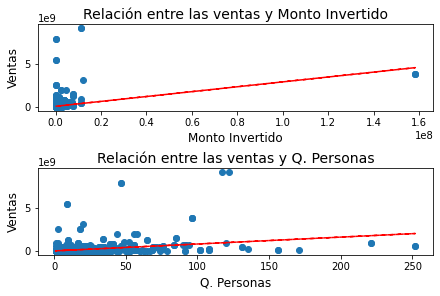

In [30]:
dtal = pd.concat([inno22[['I3R2C1','II1R1C1', 'IV4R11C3']], inno21[['I3R2C1','II1R1C1', 'IV4R11C3']]],axis=0,ignore_index=True)


# plt.plot(, y, 'o')

def example_plot(ax, i):
    dic = ['Monto Invertido', 'Q. Personas']
    ax.plot(dtal.iloc[:,i],dtal.iloc[:,0],'o')
    z = np.polyfit(dtal.iloc[:,i],dtal.iloc[:,0], 1)
    p = np.poly1d(z)
    ax.plot(dtal.iloc[:,i], p(dtal.iloc[:,i]),"r--")
    ax.set_xlabel(dic[i-1], fontsize=12)
    ax.set_ylabel('Ventas', fontsize=12)
    l = 'Relación entre las ventas y {}'.format(dic[i-1])
    ax.set_title(l, fontsize=14)
    
fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True)

for i,ax in enumerate(axs.flat):
    n= i+1
    example_plot(ax,n)

## Creación de los valores de entranamiento y test
Primero para el tema de innovación

In [12]:
#En esta parte es para uno de los 2 analisis (Explicar*)
xs= [ 'I1R4C1', 'II1R1C1', 'V1R1C1', 'IV4R11C3','PCA1', 'e__10', 'e__11', 'e__13', 'e__14', 'e__15', 'e__16', 'e__17', 'e__18',
              'e__19', 'e__20', 'e__21', 'e__22', 'e__23', 'e__24', 'e__25', 'e__26',
              'e__27', 'e__28', 'e__29', 'e__30', 'e__31', 'e__32', 'e__33', 'PCA2', 'PCA3', 'PCA4'] #
ys = ['Tendencias']

X_1 = inno21[xs]
y_1 = inno21[ys]
X_2 = inno22[xs]
y_2 = inno22[ys]
X = inno2[xs]
y = inno2[ys]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Modelación (Innovación)
Explicar como se realiza la modelacion y como se realiza la evaluación

In [13]:
#Utilizando las base de datos separadas
#Entrenando con los datos mas viejos 
#Evaluando con los datos mas nuevos
rf = RandomForestClassifier(random_state=42,class_weight='balanced')
param_grid = { 
    'n_estimators': [100, 300 ,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,11,12,13,14,50],
    'criterion' :['gini', 'entropy']
}
cv_rfc2= GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)

cv_rfc2.fit(X_2, y_2)
pred_t = cv_rfc2.predict(X_1)
confusion_1 = confusion_matrix(y_1, pred_t)
print('GridSearch::', confusion_1)

GridSearch:: [[560  66]
 [318 506]]


In [14]:
acu= accuracy_score(y_1, pred_t)
prec = precision_score(y_1, pred_t)
re = recall_score(y_1, pred_t)
f1 = f1_score(y_1,pred_t)

print('''
      Separacion->
      Accuracy: {}
      Precision: {}
      Recall: {}
      F1: {}
      '''.format(acu,prec,re, f1))


      Separacion->
      Accuracy: 0.7351724137931035
      Precision: 0.8846153846153846
      Recall: 0.6140776699029126
      F1: 0.7249283667621775
      


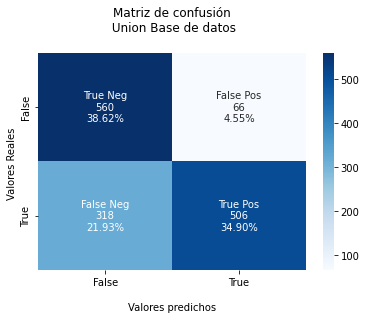

In [15]:
Matrix(y_1,pred_t)

In [16]:
#Se implementa estima el modelo encontrado
print(cv_rfc2.best_params_)
rf = RandomForestClassifier(random_state=42,class_weight='balanced',
                           criterion= 'entropy', max_depth= 14, max_features= 'log2', n_estimators= 300)
rf.fit(X_2, y_2)
pred_t = rf.predict(X_1)

{'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'n_estimators': 300}


In [17]:
#IV4R11C3 -> Total personal involucrado en Actividades Científicas, Tecnológicas y de Innovación
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_2.columns,  
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
IV4R11C3,0.201111
PCA1,0.154977
PCA2,0.137989
PCA3,0.110139
PCA4,0.109482


In [18]:
#En esta parte se realiza con los datos juntos
rf = RandomForestClassifier(random_state=42,class_weight='balanced')
param_grid = { 
    'n_estimators': [100, 300 ,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,11,12,13,14,50],
    'criterion' :['gini', 'entropy']
}
cv_rfc2= GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
cv_rfc2.fit(X_train, y_train)
pred = cv_rfc2.predict(X_test)
confusion = confusion_matrix(y_test, pred)
print('GridSearch:', confusion)

GridSearch: [[611 124]
 [221 578]]


In [19]:
#Metricas de evaluación
confusion_test = confusion_matrix(y_test, pred)
print('Confusión Balanceado y con mejores parametros\n {}', confusion_test)
 
acu= accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
re = recall_score(y_test, pred)
f1 = f1_score(y_test,pred)

print('''
      Juntos->
      Accuracy: {}
      Precision: {}
      Recall: {}
      F1: {}
      '''.format(acu,prec,re, f1))

Confusión Balanceado y con mejores parametros
 {} [[611 124]
 [221 578]]

      Juntos->
      Accuracy: 0.7750977835723598
      Precision: 0.8233618233618234
      Recall: 0.723404255319149
      F1: 0.770153231179214
      


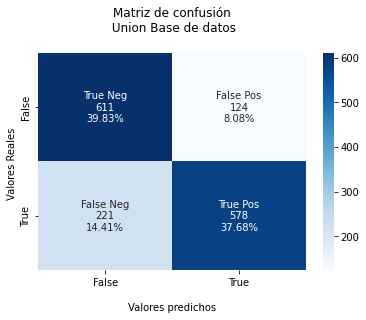

In [20]:
#Matriz de confusión
Matrix(y_test,pred)

In [21]:
print(cv_rfc2.best_params_)
rf = RandomForestClassifier(random_state=42,class_weight='balanced',
                           criterion= 'entropy', max_depth= 14, max_features= 'log2', n_estimators= 300)
rf.fit(X_train, y_train)
pred_t = rf.predict(X_test)

{'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'n_estimators': 300}


In [22]:

feature_importances = pd.DataFrame(rf.feature_importances_, index = X_2.columns,  
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
IV4R11C3,0.182859
PCA1,0.157968
PCA4,0.137067
PCA2,0.119054
PCA3,0.110117


## Modelación (Incentivos)
Explicacion de este proceso. Que diferencia esto con lo otro. 

In [23]:
Organizador(ince2, 0, False)
column = ['VIII13R1C1', 'VIII15R1C1',
       'VIII14R4C1', 'Entidad', 'Tendencias']
ince22 = ince2[column]

In [24]:
xs = ['VIII13R1C1', 'VIII15R1C1', 'VIII14R4C1']
ys = ['Tendencias']


X = ince22[xs]
y = ince22[ys]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [25]:
rf = RandomForestClassifier(random_state=42,class_weight='balanced')
param_grid = { 
    'n_estimators': [100, 300 ,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,11,12,13,14,15,16],
    'criterion' :['gini', 'entropy']
}
cv_rfc2= GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)

cv_rfc2.fit(X_train, y_train)
pred = cv_rfc2.predict(X_test)
confusion = confusion_matrix(y_test, pred)
print('GridSearch:', confusion)

GridSearch: [[259 129]
 [172 223]]


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

acu= accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
re = recall_score(y_test, pred)
f1 = f1_score(y_test,pred)

print('''
      Juntos->
      Accuracy: {}
      Precision: {}
      Recall: {}
      F1: {}
      '''.format(acu,prec,re, f1))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       388
           1       0.63      0.56      0.60       395

    accuracy                           0.62       783
   macro avg       0.62      0.62      0.61       783
weighted avg       0.62      0.62      0.61       783


      Juntos->
      Accuracy: 0.6155810983397191
      Precision: 0.6335227272727273
      Recall: 0.5645569620253165
      F1: 0.5970548862115127
      


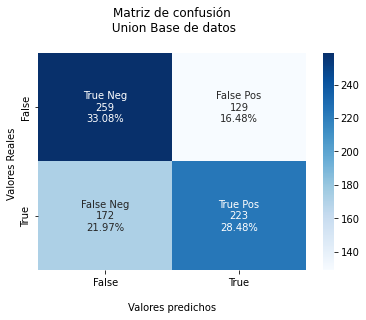

In [27]:
#Mirar si poner una funcion
Matrix(y_test, pred)

In [28]:
print(cv_rfc2.best_params_)
rf = RandomForestClassifier(random_state=42,class_weight='balanced',
                           criterion= 'gini', max_depth= 4, max_features= 'auto', n_estimators= 100)
rf.fit(X_train, y_train)
pred_t = rf.predict(X_test)

{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}


VIII15R1C1 ¿qué porcentaje de los gerentes/as recibió un bono de desempeño?. 0%=1 1-33%=2 34-66%=3 67-99%=4 100%=5 No se alcanzaron los objetivos de producción=6

VIII13R1C1 ¿qué porcentaje del personal ocupado diferente a los gerentes/as recibió un bono de desempeño?. 0%=1, 1-33%=2, 34-66%=3, 67-99%=4, 100%=5, No se alcanzaron los objetivos de producción=6

VIII14R4C1 El desempeño de la empresa medido por las metas alcanzadas.

In [29]:

feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns,  
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
VIII15R1C1,0.613999
VIII13R1C1,0.254661
VIII14R4C1,0.131340
